In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option("display.max_columns", None)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
train = pd.read_csv("C:\\scnguh\\datamining\\pubg\\all\\train_V2.csv")
test = pd.read_csv("C:\\scnguh\\datamining\\pubg\\all\\test_V2.csv")

In [3]:
# killPlace
train = train[train.killPlace <= 100]
# winPlacePerc should not be null
train = train[train.winPlacePerc >= 0 ]

In [103]:
df_all = pd.concat([train, test])

In [5]:
## Feature project, part1 Personal features

# DBNOs ratio in whole team
df1 = df_all.groupby(['groupId'], as_index=False).agg({'DBNOs':'sum'})
df1.reset_index(inplace=True, drop=True)
df1.rename(columns={'DBNOs':'DBNOs_team'}, inplace=True)
df2 = pd.merge(df_all, df1, on='groupId', how='left')
df2 = df2[['Id', 'DBNOs', 'DBNOs_team']]
df2.loc[:, 'DBNOs_ratio'] = df2.DBNOs / df2.DBNOs_team
feature1 = df2[['Id', 'DBNOs_ratio']]
feature1.fillna(0, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [6]:
# Assists ratio in whole team
df1 = df_all.groupby(['groupId'], as_index=False).agg({'assists':'sum'})
df1.reset_index(inplace=True, drop=True)
df1.rename(columns={'assists':'assists_team'}, inplace=True)
df2 = pd.merge(df_all, df1, on='groupId', how='left')
df2 = df2[['Id', 'assists', 'assists_team']]
df2.loc[:, 'assists_ratio'] = df2.assists / df2.assists_team
feature2 = df2[['Id', 'assists_ratio']]
feature2.fillna(0, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [7]:
# Damage ratio in whole team
df1 = df_all.groupby(['groupId'], as_index=False).agg({'damageDealt':'sum'})
df1.reset_index(inplace=True, drop=True)
df1.rename(columns={'damageDealt':'damageDealt_team'}, inplace=True)
df2 = pd.merge(df_all, df1, on='groupId', how='left')
df2 = df2[['Id', 'damageDealt', 'damageDealt_team']]
df2.loc[:, 'damageDealt_ratio'] = df2.damageDealt / df2.damageDealt_team
feature3 = df2[['Id', 'damageDealt_ratio']]
feature3.fillna(0, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [12]:
# Headshot ratio
df1 = df_all[['Id', 'headshotKills', 'kills']]
df1.loc[:,'headshot_ratio'] = df1.headshotKills / df1.kills
feature4 = df1[['Id', 'headshot_ratio']]
feature4.fillna(0, inplace=True)

In [11]:
# Heals ratio in whole team
df1 = df_all.groupby(['groupId'], as_index=False).agg({'heals':'sum'})
df1.reset_index(inplace=True, drop=True)
df1.rename(columns={'heals':'heals_team'}, inplace=True)
df2 = pd.merge(df_all, df1, on='groupId', how='left')
df2 = df2[['Id', 'heals', 'heals_team']]
df2.loc[:, 'heals_ratio'] = df2.heals / df2.heals_team
feature5 = df2[['Id', 'heals_ratio']]
feature5.fillna(0, inplace=True)

In [13]:
# Rank delta
df1 = df_all[['Id', 'killPlace', 'maxPlace']]
df1.loc[:,'rank_delta'] = abs(df1.killPlace - df1.maxPlace)
feature6 = df1[['Id', 'rank_delta']]

In [14]:
# Is kill place top 10
df1 = df_all[['Id', 'killPlace']]
df2 = df1[df1.killPlace <= 10]
df3 = df1[df1.killPlace > 10]
df2.loc[:,'is_killplace_top10'] = 1
df3.loc[:,'is_killplace_top10'] = 0
df4 = pd.concat([df2, df3])
feature7 = df4[['Id', 'is_killplace_top10']]

In [60]:
# Total moving distance
df1 = df_all[['Id', 'rideDistance', 'swimDistance', 'walkDistance', 'winPlacePerc']]
df1.loc[:,'total_distance'] = df1.rideDistance + df1.swimDistance + df1.walkDistance
temp1 = df1[df1.winPlacePerc >= 0][['Id', 'total_distance', 'winPlacePerc']]
'''
low: [0, 0.3]              L
medium: (0.3, 0.6]         M
medium high: (0.6, 0.85]   MH
high: (0.85, 1]            H

level  mean_distance
0     H     4097.159395
1     L      230.670046
2     M     1338.473811
3    MH     3118.616026
'''
# temp.loc[:,'level'] = temp.apply(lambda x:'L' if x[1]>=0 and x[1]<=0.3 \
#                                  else ('M' if x[1]>0.3 and x[1]<=0.6 \
#                                        else ('MH' if x[1]>0.6 and x[1]<=0.85 \
#                                              else 'H')), axis=1)
bins = [0, 230, 1338, 3118, 4097, float("inf")]
labels = ['A', 'B', 'C', 'D', 'E']
temp2 = pd.cut(temp1.total_distance, bins, labels=labels, include_lowest=True)
temp1.rename(columns={'total_distance':'total_distance1'}, inplace=True)
temp3 = pd.concat([temp1, temp2], axis=1)
temp3.drop(temp3.columns[[1, 2]], axis=1, inplace=True)
df_all.drop(['rideDistance', 'swimDistance', 'walkDistance'], axis=1, inplace=True)
feature8 = temp3

KeyError: "['rideDistance' 'swimDistance' 'walkDistance'] not in index"

In [ ]:
# Merge personal features
features = [feature1, feature2, feature3, feature4, feature5, feature6, feature7, feature8]
person_features = df_all.Id.to_frame()
for ft in features:
    person_features = pd.merge(person_features, ft, on='Id')

In [ ]:
## Group features




In [104]:
## Processing original data
# [1]
bins = [0, 500, 800, 1000, 1500, 2000, float("inf")]
labels = ["A", "B", "C", "D", "E", "F"]
out = pd.cut(df_all.damageDealt, bins, labels=labels, include_lowest=True)
df_all.rename(columns={'damageDealt':'damageDealt1'}, inplace=True)
df_all = pd.concat([df_all, out], axis=1)
df_all.drop(['damageDealt1'], axis=1, inplace=True)

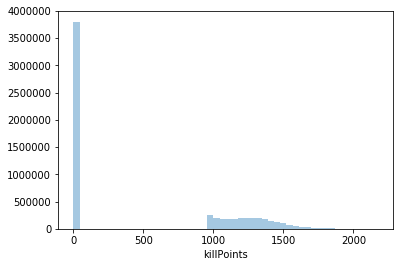

A    3804631
D    2017928
E     281538
C     256606
F      15474
B       4527
G        434
Name: killPoints, dtype: int64


In [107]:
# [2]
sns.distplot(df_all.killPoints, kde=False)
plt.show()

bins = [0, 200, 500, 1000, 1500, 1800, 2000, float("inf")]
labels = ["A", "B", "C", "D", "E", "F", "G"]
out = pd.cut(df_all.killPoints, bins, labels=labels, include_lowest=True)
count = pd.value_counts(out)
print(count)

In [ ]:
## Merge person features to original data
df = pd.merge(df_all, person_features, on='Id')
test_id = df[-len(test):].Id.values
df.drop(['Id', 'groupId', 'matchId'], 1, inplace=True)

# One-hot encode for character feature
dummy_features = pd.get_dummies(df['matchType'], prefix='matchType')
for dummy in dummy_features:
    df[dummy] = dummy_features[dummy]
df.drop(['matchType'], 1, inplace=True)

# Normalize numberic value
for index, value in df.dtypes.iteritems():
    minValue = df[index].min()
    maxValue = df[index].max()
    df[index] = df[index].apply(lambda x:(x - minValue) / (maxValue - minValue) if maxValue != minValue else 0)    

In [ ]:
# Split train/test
train = df[:-len(test)]
test = df[-len(test):] 

In [ ]:
# Modeling:xgboost
yTrain = np.array(train.winPlacePerc)
train.drop(['winPlacePerc'], 1, inplace=True)
test.drop(['winPlacePerc'], 1, inplace=True)

num_trees = 100
params = {"objective": "reg:linear",
          "eta": 0.15,
          "max_depth": 8,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }

dtrain = xgb.DMatrix(train, label=yTrain)
dtest = xgb.DMatrix(test)
watchlist = [(dtrain, 'train')]

gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, verbose_eval=True)

yhat = gbm.predict(dtest)

In [ ]:
# Save result
arr = np.vstack((test_id, yhat))
arr = arr.T
df_final = pd.DataFrame(arr, columns=['Id', 'winPlacePerc'])
df_final.to_csv("submission.csv", index=False)
print("Generated submission file!")